In [53]:
import os
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font',**{'family':'sans-serif', 'sans-serif':['Helvetica'], 'size':'20'})
plt.rcParams['figure.figsize'] = '10,10'
plt.style.use('seaborn-white')

In [55]:
df3D = pd.read_hdf('/scratch/spigazzi/MTD/TDR/TrackPUID/samples/ttbar_PMV13_v1/input_tracks_test_3D.hd5')
df4D = pd.read_hdf('/scratch/spigazzi/MTD/TDR/TrackPUID/samples/ttbar_PMV13_v1/input_tracks_test_4D.hd5')

In [56]:
print(df3D.columns, df4D.columns)

Index(['idx', 'pt', 'eta', 'phi', 'x', 'y', 'z', 'dz', 'dxy', 'dzErr',
       'dxyErr', 'chi2', 'ndof', 't0', 'sigmat0', 'mtdt', 'path_len', 'probPi',
       'probP', 'probK', 'btlMatchChi2', 'btlMatchTimeChi2', 'etlMatchChi2',
       'etlMatchTimeChi2', 'normalizedChi2', 'numberOfValidHits',
       'numberOfLostHits', 'numberOfValidPixelBarrelHits',
       'numberOfValidPixelEndcapHits', 'numberOfValidHitsBTL',
       'numberOfValidHitsETL', 'hasMTD', 'genPdgId', 'genPt', 'genEta',
       'genPhi', 'genDR', 'simIsFromPV', 'simPt', 'simEta', 'simPhi', 'simZ',
       'genVtx_x', 'genVtx_y', 'genVtx_z', 'genVtx_t', 'pv_valid', 'pv_ntrks',
       'pv_chi2', 'pv_x', 'pv_y', 'pv_z', 'pv_t', 'puid', 'pu_weight',
       'eta_pt_weight', 'weight'],
      dtype='object') Index(['idx', 'pt', 'eta', 'phi', 'x', 'y', 'z', 'dz', 'dxy', 'dzErr',
       'dxyErr', 'chi2', 'ndof', 't0', 'sigmat0', 'mtdt', 'path_len', 'probPi',
       'probP', 'probK', 'btlMatchChi2', 'btlMatchTimeChi2', 'etlMatchChi2',

In [61]:
features = [
    'pt',
    'eta',
    'phi',
    'dxy',
    'dz',
    'dzErr',
    'dxyErr',
    'chi2',
    'ndof',
    'numberOfValidHits',
    'numberOfValidPixelBarrelHits',
    'numberOfValidPixelEndcapHits'
]

MTD_features = [
#    'dt',
#    'sigmat0',
    'btlMatchChi2',
    'btlMatchTimeChi2',
    'etlMatchChi2',
    'etlMatchTimeChi2',
    'mtdt',
    'path_len'
]

target = 'simIsFromPV'

# df3D['dx'] = abs(df3D['x']-df3D['pv_x'])
# df3D['dy'] = abs(df3D['y']-df3D['pv_y'])
# df3D['dz'] = abs(df3D['z']-df3D['pv_z'])

# df4D['dx'] = abs(df4D['x']-df4D['pv_x'])
# df4D['dy'] = abs(df4D['y']-df4D['pv_y'])
# df4D['dz'] = abs(df4D['z']-df4D['pv_z'])
df4D['dt'] = df4D['t0']-df4D['pv_t']

event_sel3D = (df3D['pt']>0.7) & (abs(df3D['eta'])<3.)
event_sel4D = (df4D['pt']>0.7) & (abs(df4D['eta'])<3.)

df3D = df3D[event_sel3D]
df4D = df4D[event_sel4D]

X_3D = df3D[features]
y_3D = df3D[target]
w_3D = df3D['weight']
X_4D = df4D[features + MTD_features]
y_4D = df4D[target]
w_4D = df4D['weight']

#print(w.sum())

In [46]:
import pickle
with open("/scratch/spigazzi/MTD/TDR/TrackPUID/results/ttbar_PMV13_v1/track_puid_optimized_clf3D.pkl", "rb") as f:
    clf3D = pickle.load(f)
    ntress3D = pickle.load(f)
    res3D = pickle.load(f)

clf3D.get_booster().set_param('predictor', 'cpu_predictor')
y_pred_prob_3D = clf3D.predict_proba(X_3D)

[17:41:42] /workspace/src/learner.cc:362: Parameter 'predictor' has been recovered from the saved model. It will be set to 'gpu_predictor' for prediction. To override the predictor behavior, explicitly set 'predictor' parameter as follows:
  * Python package: bst.set_param('predictor', [new value])
  * R package:      xgb.parameters(bst) <- list(predictor = [new value])
  * JVM packages:   bst.setParam("predictor", [new value])


In [67]:
with open("/scratch/spigazzi/MTD/TDR/TrackPUID/results/ttbar_PMV13_MTDquality_v1/track_puid_optimized_clf4D.pkl", "rb") as f:
    clf4D = pickle.load(f)
    ntress4D = pickle.load(f)
    res4D = pickle.load(f)

clf4D.get_booster().set_param('predictor', 'cpu_predictor')    
y_pred_prob_4D = clf4D.predict_proba(X_4D)

In [48]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.ticker as plticker

select3D = (abs(X_3D['eta'])<3)
select4D = (abs(X_4D['eta'])<3) & (X_4D[select4D]['sigmat0']>0) & (abs(X_4D[select4D]['dz'])<0.1)
#& (X_4D['sigmat0']>0) 

rocDz = roc_curve(y_3D[select3D], 1.-abs(X_3D[select3D]['dz'])/abs(X_3D[select3D]['dz']).max(), sample_weight=w_3D[select3D])

# dzt_max = (pow(X['dz']/X['dzErr'], 2) + pow(X['dt']/X['sigmat0'], 2)).max()
# rocDzt = roc_curve(y, 1.-(pow(X['dz']/X['dzErr'], 2) + pow(X['dt']/X['sigmat0'], 2))/dzt_max, sample_weight=w)

# dt_max = abs(X['dt']/X['sigmat0']).max()
# X['dzt'] = 1.-abs(X['dt']/X['sigmat0'])/dt_max
# X.loc[X['dz']>0.1, 'dzt'] = 0.
# rocDt_dz1mm = roc_curve(y, X['dzt'] , sample_weight=w)

roc3D = roc_curve(y_3D[select3D], y_pred_prob_3D[select3D][:,1], sample_weight=w_3D[select3D])

roc4D = roc_curve(y_4D[select4D], y_pred_prob_4D[select4D][:,1], sample_weight=w_4D[select4D])

fig, ax = plt.subplots()
hrocDz = plt.plot(rocDz[1], 1-rocDz[0], label='dz')
# hrocDzt = plt.plot(rocDzt[1], 1-rocDzt[0], label='dzt')
# hrocDt_dz1mm = plt.plot(rocDt_dz1mm[1], 1-rocDt_dz1mm[0], label='dt, dz<1 mm')
hroc3D = plt.plot(roc3D[1], 1-roc3D[0], label='3D BDT')
hroc4D = plt.plot(roc4D[1], 1-roc4D[0], label='4D BDT')
plt.xlabel('PV track efficiency')
plt.ylabel('PU track rejection')
ticks = plticker.MultipleLocator(base=0.1)
#ax.set_ylim(0.8, 1.05)
ax.xaxis.set_major_locator(ticks)
ax.yaxis.set_major_locator(ticks)
plt.grid()
plt.legend()
# fig.savefig("plot/ttbar_PMV13_v1/roc_comparison.png", bbox_inches='tight')
# fig.savefig("plot/ttbar_PMV13_v1/roc_comparison.pdf", bbox_inches='tight')

print(roc_auc_score(y_3D[select3D], 1.-abs(X_3D[select3D]['dz'])/abs(X_3D[select3D]['dz']).max(), sample_weight=w_3D),
      roc_auc_score(y_3D, y_pred_prob_3D[:,1], sample_weight=w_3D),
      roc_auc_score(y_4D, y_pred_prob_4D[:,1], sample_weight=w_4D)
)

ValueError: cannot reindex from a duplicate axis

In [9]:
scaled_rej3D = [ roc3D[0][np.abs(roc3D[1]-eff).argmin()] for eff in roc4D[1] if eff<0.99]

/t3home/spigazzi/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


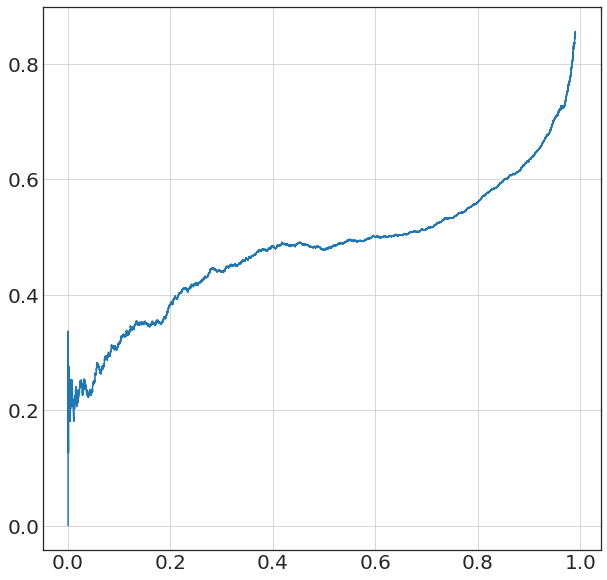

In [11]:
scaled_rej4D = [ roc4D[0][i[0]] for i, eff in np.ndenumerate(roc4D[1]) if eff<0.99]
scaled_eff4D = [ eff for eff in roc4D[1] if eff<0.99]
h = plt.plot(scaled_eff4D, np.array(scaled_rej4D)/np.array(scaled_rej3D))
plt.grid()

In [12]:
eff_at_bestrej = scaled_eff4D[h[0].get_ydata()[1:].argmax()+1]
print('eff', '\t', '3D-thr', '\t', '4D-thr', '\t', '3D-residual-pu', '\t', '4D-residual-pu')
print(0.97, '\t', roc3D[2][(np.abs(roc3D[1] - eff_at_bestrej)).argmin()], '\t', roc4D[2][(np.abs(roc4D[1] - eff_at_bestrej)).argmin()], '\t',
      roc3D[0][(np.abs(roc3D[1] - eff_at_bestrej)).argmin()], '\t', roc4D[0][(np.abs(roc4D[1] - eff_at_bestrej)).argmin()])

## 95%
print(str(0.95), '\t', roc3D[2][(np.abs(roc3D[1] - 0.95)).argmin()], '\t', roc4D[2][(np.abs(roc4D[1] - 0.95)).argmin()], '\t',
      roc3D[0][(np.abs(roc3D[1] - 0.95)).argmin()], '\t', roc4D[0][(np.abs(roc4D[1] - 0.95)).argmin()])

## 90%
print(0.90, '\t', roc3D[2][(np.abs(roc3D[1] - 0.90)).argmin()], '\t', roc4D[2][(np.abs(roc4D[1] - 0.90)).argmin()], '\t',
      roc3D[0][(np.abs(roc3D[1] - 0.90)).argmin()], '\t', roc4D[0][(np.abs(roc4D[1] - 0.90)).argmin()])

## 80%
print(0.80, '\t', roc3D[2][(np.abs(roc3D[1] - 0.80)).argmin()], '\t', roc4D[2][(np.abs(roc4D[1] - 0.80)).argmin()], '\t',
      roc3D[0][(np.abs(roc3D[1] - 0.80)).argmin()], '\t', roc4D[0][(np.abs(roc4D[1] - 0.80)).argmin()])


eff 	 3D-thr 	 4D-thr 	 3D-residual-pu 	 4D-residual-pu
0.97 	 0.997497 	 0.99923384 	 0.0 	 0.0
0.95 	 0.4976366 	 0.50645936 	 0.08885290643344576 	 0.06264330981005464
0.9 	 0.7228171 	 0.7534892 	 0.06072548780087395 	 0.03841302701188362
0.8 	 0.85820836 	 0.8905244 	 0.03725202655971608 	 0.020859396153855063


In [50]:
df3D['3dbdt_score'] = y_pred_prob_3D[:,1]
df4D['4dbdt_score'] = y_pred_prob_4D[:,1]

In [45]:
thrDz = rocDz[2][(np.abs(rocDz[1] - 0.9)).argmin()]
print(thrDz)
thr3D = roc3D[2][(np.abs(roc3D[1] - 0.9)).argmin()]
print(thr3D)
thr4D = roc4D[2][(np.abs(roc4D[1] - 0.9)).argmin()]
print(thr4D)

0.8996344581246376
0.7228171
0.40383992


In [46]:
from scipy.stats import norm
linden_bins = np.linspace(0, 1.9, 10)
linden = [(linden_bins[i]+linden_bins[i-1])/2 for i in range(1, len(linden_bins))]
linden_data3D = df3D.groupby(pd.cut(df3D['pv_z'], np.linspace(0, 1.9, 10)))
linden_data4D = df4D.groupby(pd.cut(df4D['pv_z'], np.linspace(0, 1.9, 10)))
# = 20*norm.pdf(linden_bins, 0, 4.2)
#dz_pu = plt.plot

In [47]:
eff_dz1mm = []
eff_3Dbdt = []
eff_4Dbdt = []
purej_dz1mm = []
purej_3Dbdt = []
purej_4Dbdt = []
for h, data in linden_data3D:
    # PV eff
    eff_dz1mm.append(data[(data['dz']<0.1) & (data['pt']>0.7) & (abs(data['eta'])<3.) & data['simIsFromPV']].size/data[data['simIsFromPV'] & (data['pt']>0.7) & (abs(data['eta'])<3.)].size)
    eff_3Dbdt.append(data[(data['3dbdt_score']>(thr3D)) & (data['pt']>0.7) & (abs(data['eta'])<3.) & data['simIsFromPV']].size/data[data['simIsFromPV'] & (data['pt']>0.7) & (abs(data['eta'])<3.)].size)
for h, data in linden_data4D:    
    eff_4Dbdt.append(data[(data['4dbdt_score']>(thr4D)) & (data['pt']>0.7) & (abs(data['eta'])<3.) & data['simIsFromPV']].size/data[data['simIsFromPV']].size)
    # PU rejection
for h, data in linden_data3D:    
    purej_dz1mm.append(data[(data['dz']<0.1) & (data['pt']>0.7) & (abs(data['eta'])<3.) & (data['simIsFromPV']==0)].size/data[(data['simIsFromPV']==0) & (data['pt']>0.7) & (abs(data['eta'])<3.)].size)
    purej_3Dbdt.append(data[(data['3dbdt_score']>(thr3D)) & (data['pt']>0.7) & (abs(data['eta'])<3.) & (data['simIsFromPV']==0)].size/data[(data['simIsFromPV']==0) & (data['pt']>0.7) & (abs(data['eta'])<3.)].size)
for h, data in linden_data4D:    
    purej_4Dbdt.append(data[(data['4dbdt_score']>(thr4D)) & (data['pt']>0.7) & (abs(data['eta'])<3.) & (data['simIsFromPV']==0)].size/data[(data['simIsFromPV']==0) & (data['pt']>0.7) & (abs(data['eta'])<3.)].size)



In [48]:
eff_dz = []
eff_3Dbdt = []
eff_4Dbdt = []
purej_dz = []
purej_3Dbdt = []
purej_4Dbdt = []
for h, data in linden_data3D:
    # PV eff
    eff_dz.append(data[(1-data['dz']/X_3D['dz']<0.1) & data['simIsFromPV']].size/data[data['simIsFromPV']].size)
    eff_3Dbdt.append(data[(data['3dbdt_score']>(thr3D)) & data['simIsFromPV']].size/data[data['simIsFromPV']].size)
for h, data in linden_data4D:    
    eff_4Dbdt.append(data[(data['4dbdt_score']>(thr4D)) & data['simIsFromPV']].size/data[data['simIsFromPV']].size)
    # PU rejection
for h, data in linden_data3D:    
    purej_dz.append(data[(1-data['dz']/X_3D['dz'].max()>thrDz) & (data['simIsFromPV']==0)].size/data[(data['simIsFromPV']==0)].size)
    purej_3Dbdt.append(data[(data['3dbdt_score']>(thr3D)) & (data['simIsFromPV']==0)].size/data[(data['simIsFromPV']==0)].size)
for h, data in linden_data4D:    
    purej_4Dbdt.append(data[(data['4dbdt_score']>(thr4D)) & (data['simIsFromPV']==0)].size/data[(data['simIsFromPV']==0)].size)



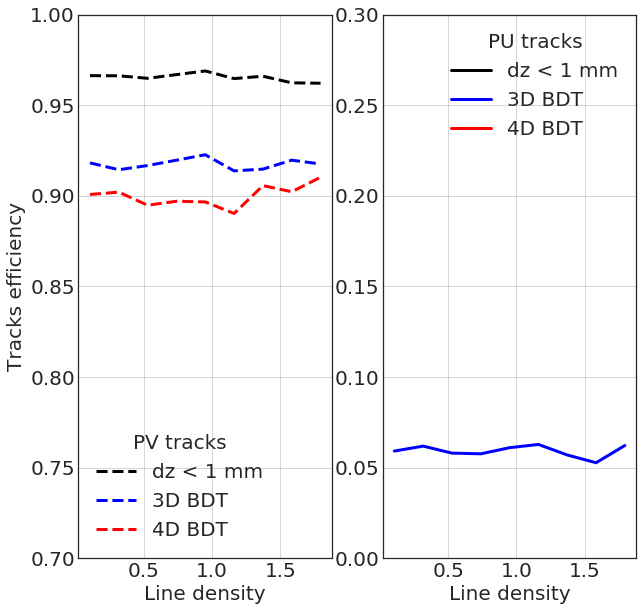

In [49]:
c = plt.subplots(nrows=1, ncols=2)[1]
h_eff_dz1mm = c[0].plot(linden, eff_dz1mm, label='dz < 1 mm', color='black', linewidth=3, linestyle='--')
h_eff_3Dbdt = c[0].plot(linden, eff_3Dbdt, label='3D BDT', color='blue', linewidth=3, linestyle='--')
h_eff_4Dbdt = c[0].plot(linden, eff_4Dbdt, label='4D BDT', color='red', linewidth=3, linestyle='--')
c[0].set_xlabel('Line density')
c[0].set_ylabel('Tracks efficiency')
c[0].set_ylim(0.7, 1.)
c[0].legend(title='PV tracks')
c[0].grid()
h_purej_dz1mm = c[1].plot(linden, purej_dz1mm, label='dz < 1 mm', color='black', linewidth=3)
h_purej_3Dbdt = c[1].plot(linden, purej_3Dbdt, label='3D BDT', color='blue', linewidth=3)
h_purej_4Dbdt = c[1].plot(linden, purej_4Dbdt, label='4D BDT', color='red', linewidth=3)
c[1].set_xlabel('Line density')
c[1].set_ylim(0, 0.3)
c[1].legend(title='PU tracks')
c[1].grid()

ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

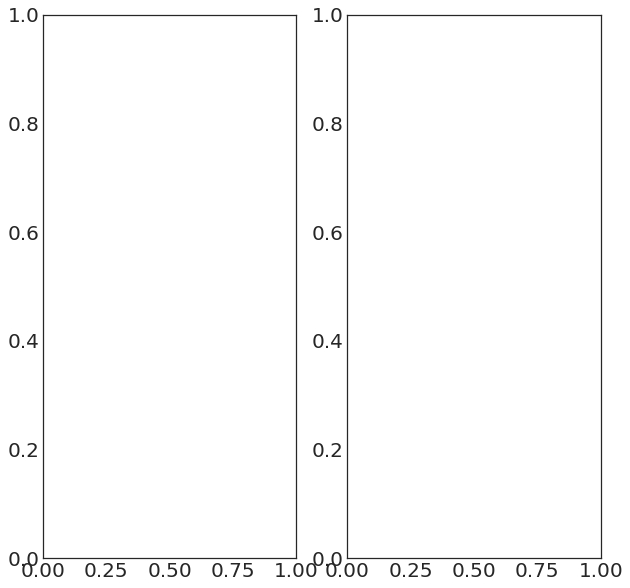

ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

In [21]:
c, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
h_eff_dz = ax1.plot(linden, eff_dz, label='dz', color='black', linewidth=3, linestyle='--')
h_eff_3Dbdt = ax1.plot(linden, eff_3Dbdt, label='3D BDT', color='blue', linewidth=3, linestyle='--')
h_eff_4Dbdt = ax1.plot(linden, eff_4Dbdt, label='4D BDT', color='red', linewidth=3, linestyle='--')
ax1.set_xlabel('Line density')
ax1.set_ylabel('Tracks efficiency')
ax1.set_ylim(0.8, 1.)
ax1.legend(title='PV tracks')
ax1.grid()
h_purej_dz = ax2.plot(linden, purej_dz, label='dz', color='black', linewidth=3)
h_purej_3Dbdt = ax2.plot(linden, purej_3Dbdt, label='3D BDT', color='blue', linewidth=3)
h_purej_4Dbdt = ax2.plot(linden, purej_4Dbdt, label='4D BDT', color='red', linewidth=3)
ticks = plticker.MultipleLocator(base=0.05)
ax2.yaxis.set_major_locator(ticks)
ax2.set_xlabel('Line density')
ax2.set_ylim(0, .3)
ax2.legend(title='PU tracks')
ax2.grid()

In [22]:
#h = plt.hist(df.loc[df['simIsFromPV']==0, '4dbdt_score']-df.loc[df['simIsFromPV']==0, 'puid_4D'], bins=100, density=True)
h = plt.hist(df.loc[df['simIsFromPV']==0, '3dbdt_score']-1/(1+np.sqrt(1/df.loc[df['simIsFromPV']==0, 'puid_3D']-1)), bins=100, alpha=0.5)
#h = plt.hist(df.loc[df['simIsFromPV']==0, '3dbdt_score'], bins=100, density=True, alpha=0.5)
#h = plt.hist(1/(1+np.sqrt(1/df.loc[df['simIsFromPV']==0, 'puid_3D']-1)), bins=100, density=True, alpha=0.5)
plt.yscale('linear')

NameError: name 'df' is not defined

In [68]:
from xgboost2tmva import convert_model
#vars = [(var, 'F') for var in features]
#convert_model(clf3D.get_booster().get_dump(), input_variables=vars, output_xml='test_gist_clf3D.xml')
features4D = ['pt', 'eta', 'phi', 'chi2', 'ndof', 'numberOfValidHits', 'numberOfValidPixelBarrelHits', 'numberOfValidPixelEndcapHits']
features4D.extend(MTD_features)
print(features4D)
vars = [(var, 'F') for var in features4D]
convert_model(clf4D.get_booster().get_dump(), input_variables=vars, output_xml='test_gist_clf4D.xml')


['pt', 'eta', 'phi', 'chi2', 'ndof', 'numberOfValidHits', 'numberOfValidPixelBarrelHits', 'numberOfValidPixelEndcapHits', 'btlMatchChi2', 'btlMatchTimeChi2', 'etlMatchChi2', 'etlMatchTimeChi2', 'mtdt', 'path_len']


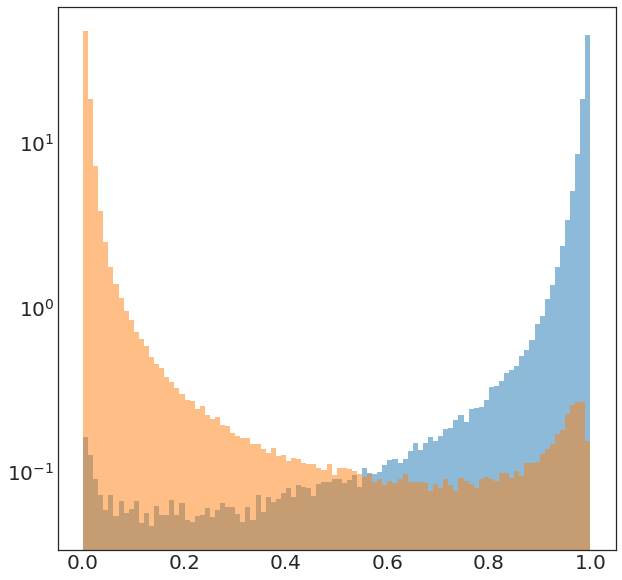

In [51]:
#h = plt.hist(df3D.loc[df3D['simIsFromPV']==0, 'dz'], bins=100, range=(-1, 1.), alpha=0.5)
#h = plt.hist(df3D.loc[(df3D['genDR']>0.3) | (abs(df3D['genPt']/df3D['pt']-1)>0.1), 'dz'], bins=100, range=(-1, 1.), alpha=0.5)
#h = plt.hist(df4D.loc[df4D['simIsFromPV']==1, 'puid'], bins=100, range=(0, 1), alpha=0.5, density=True)
h = plt.hist(df4D.loc[(df4D['simIsFromPV']==1)  & (df4D['sigmat0']>0), '4dbdt_score'], bins=100, range=(0, 1.), alpha=0.5, density=True)
h = plt.hist(df4D.loc[(df4D['simIsFromPV']==0)  & (df4D['sigmat0']>0), '4dbdt_score'], bins=100, range=(0, 1.), alpha=0.5, density=True)
#h = plt.hist(df4D.loc[df4D['simIsFromPV']==0, 'pt'], bins=100, range=(0., 10.), alpha=0.5, density=True)
#h = plt.hist(df3D.loc[df3D['simIsFromPV']==1, 'pt'], bins=100, range=(0., 100.), alpha=0.5, density=True)
#h = plt.hist(df3D.loc[df3D['simIsFromPV']==0, 'dx'], bins=100, range=(0., 0.1), alpha=0.5, density=True)
#h = plt.hist(df3D.loc[df3D['simIsFromPV']==1, 'chi2']/df3D.loc[df3D['simIsFromPV']==1, 'ndof'], bins=100, range=(0, 5), alpha=0.5, density=True)
#h = plt.hist(df3D.loc[df3D['simIsFromPV']==0, 'chi2']/df3D.loc[df3D['simIsFromPV']==0, 'ndof'], bins=100, range=(0, 5), alpha=0.5, density=True)

plt.yscale('log')

In [60]:
#clf3D.save_model("test_xgbmodel_clf3D.model")
clf4D.save_model("test_xgbmodel_clf4D.model")